# Chose 4 different regression techniques

## Read data
Only one file awailable, test dataset will be a part of the main dataset:
`data/diamonds/diamonds.csv`

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [14]:
diamonds = pd.read_csv('data/diamonds/diamonds.csv')
diamonds.drop('Unnamed: 0', axis=1, inplace=True)

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [15]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


## Preprocessing (without scaling)
Preprocessing is needed because data contains ordinal features. We have now two possibilities to encode them:
- one Hot encoding: every unique value gets its own feature
- label encoding: every value gets a number assigned (implies that the features have ratio-scale)

### Label encoding

In [16]:
cuts = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
colors = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarities = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
diamonds['cut'] = diamonds['cut'].apply(lambda x: cuts.index(x))
diamonds['color'] = diamonds['color'].apply(lambda x: colors.index(x))
diamonds['clarity'] = diamonds['clarity'].apply(lambda x: clarities.index(x))

In [17]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null int64
color      53940 non-null int64
clarity    53940 non-null int64
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(4)
memory usage: 4.1 MB


## Feature Pearson Correlation

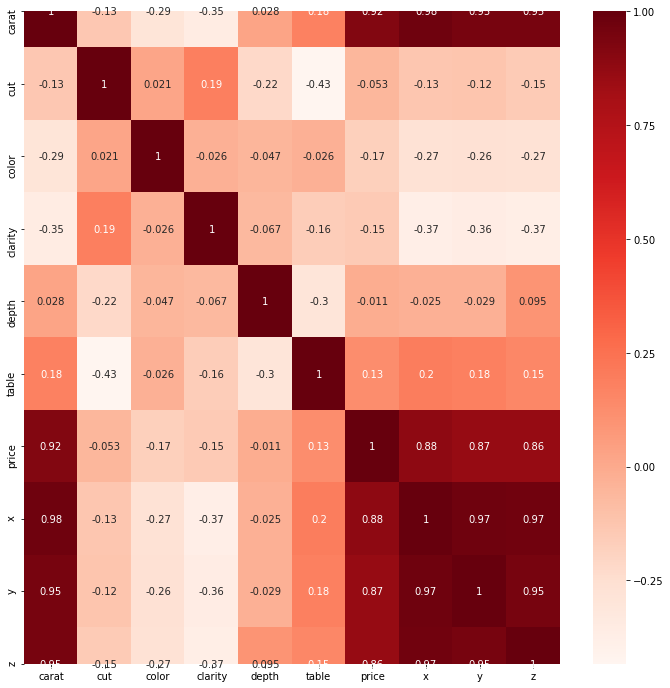

In [18]:
plt.figure(figsize=(12,12))
cor = diamonds.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Creating feature and target arrays

### Icreasing performance for all techniques but RF by dropping workingday, temp (and mnth) 

In [20]:
#diamonds_dropped = diamonds.drop(['x'], axis = 1)
diamonds_dropped = diamonds

In [21]:
X = diamonds_dropped.drop('price', axis = 1).values
y = diamonds_dropped['price'].values

## Creating train and test data 


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Ridge regression
__Score history:__
- Test set RMSE of rf: 1201.245 (base version, label encoding)

### Ridge parameters
- __alpha:__
    - regularization strenght: the higher the value, the stronger the regularization
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [29]:
# create parameter list for ridge regression
params_ridge = {
    'alpha':[x/100. for x in range(0,500,10)],
    'normalize': [True, False],
    'fit_intercept': [True, False]
}

ridge = Ridge()

In [30]:
# setup cross validation parameter grid search
grid_ridge = GridSearchCV(estimator=ridge,
    param_grid=params_ridge,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [31]:
# fitting model on training data
grid_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    7.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
                                   1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
                                   2.7, 2.8, 2.9, ...],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_ridge.best_params_

{'alpha': 0.9, 'fit_intercept': True, 'normalize': False}

In [28]:
# predicting values and calculating the rmse-score
y_pred_ridge = grid_ridge.predict(X_test)
rmse_test_ridge = MSE(y_test, y_pred_ridge)**(1/2)
print('Test set RMSE of rf: {:.3f}'.format(rmse_test_ridge))

Test set RMSE of rf: 1201.245


## Lasso regression
__Score history:__
- Test set RMSE of rf: 1201.65 (base version, label encoding

### Lasso Parameters:
- __alpha:__
    - constant that multiplies the L1-Norm
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized
- __positive:__
    - when `True` forces the coefficients to be positive

In [32]:
from sklearn.linear_model import Lasso

In [33]:
params_lasso = {
    'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
    'normalize': [True, False],
    'fit_intercept': [True, False],
    'positive': [True, False] 
}

lasso = Lasso()

In [34]:
grid_lasso = GridSearchCV(estimator=lasso,
    param_grid=params_lasso,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [35]:
grid_lasso.fit(X_train, y_train)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511868819.4062576, tolerance: 40019266.62496866
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17645689106.001495, tolerance: 40019266.62496866
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18596842896.691326, tolerance: 79874809.41250001
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19229710990.152054, tolerance: 80412628.0091
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18542850114.095478, tolerance: 79874809.41250001
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18670031079.43927, tolerance: 78836678.3128
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19229710990.152054, to

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19094151551.534065, tolerance: 80412628.0091
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18429244501.55928, tolerance: 79874809.41250001
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18630229627.93873, tolerance: 78836678.3128
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19094151551.534065, tol

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1, 1.1, 1.2],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [36]:
grid_lasso.best_params_

{'alpha': 1.2, 'fit_intercept': True, 'normalize': False, 'positive': False}

In [37]:
y_pred_lasso = grid_lasso.predict(X_test)
rmse_test_lasso = MSE(y_test, y_pred_lasso)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_lasso))

Test set RMSE of rf: 1201.65


## Random Forest
__Score history:__
- Test set RMSE of rf: 536.55 (base version, label encoding)

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
rf = RandomForestRegressor(random_state=42)

In [40]:
# take a look at the rf's parameters
print(rf.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [41]:
params_rf = {
    'n_estimators': [100],
    'max_depth': [None, 20, 21, 22],
    'min_samples_split': [2, 3, 4]
}

grid_rf = GridSearchCV(estimator=rf,
    param_grid=params_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [42]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [None, 20, 21, 22],
  

In [43]:
grid_rf.best_params_

{'max_depth': 21, 'min_samples_split': 3, 'n_estimators': 100}

In [44]:
y_pred = grid_rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 536.55


## Creating SVM
__Score history:__
- Test set RMSE of rf: 143.46
- Test set RMSE of rf: 140.58(remove workingday, temp(, mnth))

### SVM parameters
- __c:__
    - penalty parameeter (higher => overfitting)
- __shrinking:__
    - weather to use the shrinking heuristic
- __kernel:__
    - specifies the kernel type

In [45]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [46]:
scaler = RobustScaler()
svr = SVR()

In [47]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [48]:
pipe = make_pipeline(scaler, svr)

In [49]:
params_svr = {'svr__C': [1.0, 1.1, 1.2, 1.3, 1.4],
 'svr__kernel': ['rbf', 'linear', 'poly', 'rbf', 'sigmoid'],
 'svr__shrinking': [True, False]}

grid_svr = GridSearchCV(estimator=pipe,
    param_grid=params_svr,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [ ]:
grid_svr.fit(X_train, y_train)

In [ ]:
y_pred_svr = grid_svr.predict(X_test)
rmse_test_svr = MSE(y_test, y_pred_svr)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_svr))


## Creating a GradientBoostingRegressor
__Score history:__
- Test set RMSE of rf: 529.92 (base version, label encoding)

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
gbt = GradientBoostingRegressor(random_state=42)


In [57]:
params_gbt = {
'n_estimators': [200],
'max_depth': [1, 2, 3, 4, 5, 6, 7],
'max_features': ['log2'],
'learning_rate': [0.05, 0.1, 0.15],
'subsample': [0.8]
    
}
# Instantiate 'grid_rf'
grid_gbt = GridSearchCV(estimator=gbt,
param_grid=params_gbt,
cv=3,
scoring='neg_mean_squared_error',
verbose=1,
n_jobs=-1)

In [58]:
grid_gbt.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [59]:
grid_gbt.best_params_

{'learning_rate': 0.05,
 'max_depth': 7,
 'max_features': 'log2',
 'n_estimators': 200,
 'subsample': 0.8}

In [60]:
best_model = grid_gbt.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 529.92
